In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir( os.path.join('..', '..', 'notebook_format') )
from formats import load_style
load_style(css_style = 'custom2.css')

In [2]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6 # change default figure size
plt.rcParams['font.size'] = 12 # and font size

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload 
%autoreload 2

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,scikit-learn

Ethen 2016-12-12 21:12:58 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.2
pandas 0.18.1
matplotlib 1.5.1
scikit-learn 0.18


# Gradient Boosting Machine (GBM)

Just like [Random Forest and Extra Trees](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/trees/random_forest.ipynb), Gradient Boosting Machine is also a type of Ensemble Tree method, the only difference is it is stemmed from the the boosting framework. The idea of boosting is to add a weak classifier to the ensemble at a time, and this newly added weak classifier is trained to improve on the already trained ensemble. Meaning it will pay higher attention on examples which are misclassiﬁed or have higher errors and focus on mitigating those errors. Boosting is a general framework can be applied to any sort of weak learner, although Decision Tree models is by far the commonly used due to the fact that they have the flexibility to be weak learners by simply restricting their depth and they are quite fast to train.

Suppose we are given some dataset $(x_1, y_1), (x_2, y_2), ...,(x_n, y_n)$, and the task is to fit a model $F(x)$ to minimize square loss. After training the model, we discovered the model is good but not perfect.
There are some mistakes: $F(x_1) = 0.8$, while $y_1 = 0.9$, and $F(x_2) = 1.4$ while $y_2 = 1.3$ .... Now the question is, how can we improve this model without changing anything from $F(x)$?

How about we simply add an additional model (e.g. regression tree) $h$ to the already existing $F$, so the new prediction becomes $F(x) + h(x)$. In other words, we wish to improve upon the existing model so that $F(x_1) + h(x_1) = y_1, F(x_2) + h(x_2) = y_2 ...$ or equivalent we wish to a new model $h$ such that $h(x_1) = y_1 - F(x_1), h(x_2) = y_2 - F(x_2) ...$. The idea is all well and good, but the bad news is probably no model $h$ (e.g. regression tree) will be able to do this perfectly. Fortunately, the good news is, some $h$ might be able to do this approximately.

The idea is, we fit the model $h$ to the data using $y_1 - F(x_1), y_2 - F(x_2)$ as the response variable. And the intuition for this is: the $y_i - F(x_i)$s are the residuals. These are the areas that the existing
model $F$ cannot do well, so now the role of $h$ is to compensate the shortcoming of existing model $F$. And if the model after adding the new model $h$, $F + h$ is still unsatisfactory, we will just add another new one.

To make sure we're actually learning the residuals, we'll employ the idea of gradient descent. Say our goal is to minimize $J$, an overall loss function additively calculated from all observations with regard to $F$, a classifier with some parameters. More formally, we're given the formula:

$$J(y, F) = \sum_i^n L\big(y_i, F(x_i)\big)$$

Where:

- $L$ is a cost/loss function comparing the response variable's value and the prediction of the model for each observation

Instead of trying to solve it directly, gradient descent is an iterative technique that allows us to approach the solution of an optimization problem. At each step of the algorithm, it will perform the following operations:

$$F_b(x_i) = F_{b-1}(x_i) - \eta \times \nabla L\big(y_i, F(x_i)\big)$$

Where:

- $F_b$ is the version of classifier at step/iteration $b$
- $\eta$ is the learning rate which controls the size of the learning process
- $\nabla$ is the gradient i.e. the first order partial derivative of the cost function with respect to the classifier
- The formula above actually refers to stochastic gradient descent only computing the function for a single observation, $x_i$

For example, say we're given, sum squares of errors, a well-known quality indicator for regression model as our loss function. So now our loss function $L\big(y_i, F(x_i)\big)$ is defined as: $\frac{1}{2} \big( y_i - F(x_i) \big)^2$ (the 1/2 is simply to make the notation cleaner later). Taking the gradient of this loss function we get:

$$\frac{ \partial L\big(y_i, F(x_i)\big) }{ \partial F(x_i) } = \frac{ \partial \frac{1}{2} \big( y_i - F(x_i) \big)^2 }{ \partial F(x_i) } = F(x_i) - y_i$$

Tying this back to our original problem, we wish to update our function $F$ at iteration $b$ with a new model $h$:

\begin{align}
F_b(x_i) &= F_{b-1}(x_i) + h(x_i) \nonumber \\
         &= F_{b-1}(x_i) + y_i - F_{b-1}(x_i) \nonumber \\
         &= F_{b-1}(x_i) - 1 \times \frac{ \partial L\big(y_i, F_{b-1}(x_i)\big) }{ \partial F_{b-1}(x_i) }
\end{align}

As we can see, the formula above is 99% the same as as the gradient descent formula, $F_b(x_i) = F_{b-1}(x_i) - \eta \times \nabla L\big(y_i, F(x_i)\big)$. The only difference is that the learning rate $\eta$ is  1. Thus, we now have an iterative process constructing the additive model that minimizes our loss function (residuals).

In practice though, Gradient Boosting Machine is more prone to overfitting, since the week learner is tasked with optimally fitting the gradient. This means that boosting will select the optimal learner at each stage of the algorithm, although this strategy generates an optimal solution at the current stage, it has the drawbacks of not finding the optimal global model as well as overfitting the training data. A remedy for greediness is to constrain the learning process by setting the learning rate $\eta$ (also known as shrinkage). In the above algorithm, instead of directly adding the predicted value for a sample to next iteration's predicted value, so that only a fraction of the current predicted value is added to the previous iteration's predicted value. This parameter can take values between 0 and 1 and becomes another tuning parameter for the model. Small values of the learning parameter such as 0.1 tends to work better, but the value of the parameter is inversely proportional to the computation time required to find an optimal model, because more iterations are necessary.

To sum it all up in english the process of training a gradient boosting machine for regression is:

1. Initialize a predicted value for each observation (e.g. the original response or the average response or a value that minimizes the loss function). This will be our initial "residuals", $r$ (it can be called the residuals because we're dealing with a regression task, but often times this quantity is referred to as the negative gradient, so that the $- \nabla \times L\big(y_i, F(x_i) \big)$ part generalizes to any loss function we might want to use).
2. For step = 1 to $B$ (number of iterations that we specify) do:

    - Fit a regression tree $F_b$ to the training data $(X, r)$, where we use the residuals as the response variable
    - Update model $F$ by adding a shrunken version of the newly fitted regression tree. In code, this this basically mean we append the new tree to the array of trees we've already stored: 
    $F_{b + 1}(X) = F_{b}(X) + \eta F_{b}(X)$
    - Update each observation's residual by adding the predicted value to it:
    $r_{b + 1} = r_b - \eta F_b(X)$
3. Our final output boosted model is simply $F(x) = \sum_{b = 1}^B \eta F_b(x)$, where we sum the values that each individual tree gives (times the learning rate).

## Implementation

Here, we will use the [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) to test our implementation. This [link](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv) should download the .csv file. The task is to predict the quality of the wine (a scale of 1 ~ 10) given some of its features.

In [3]:
# read in the data and shuffle the row order for model stability
np.random.seed(4321)
wine_path = os.path.join('..', 'winequality-white.csv')
wine = pd.read_csv(wine_path, sep = ';')
wine = wine.sample(frac = 1)

# train/test split the features and response column
y = wine['quality'].values
X = wine.drop('quality', axis = 1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

print('dimension of the dataset: ', wine.shape)
wine.head()

dimension of the dataset:  (4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
216,7.5,0.27,0.36,7.00,0.036,45.0,164.0,0.99390,3.03,0.33,11.0,5
271,5.2,0.60,0.07,7.00,0.044,33.0,147.0,0.99440,3.33,0.58,9.7,5
3598,5.8,0.20,0.24,1.40,0.033,65.0,169.0,0.99043,3.59,0.56,12.3,7
3378,6.1,0.28,0.27,4.70,0.030,56.0,140.0,0.99042,3.16,0.42,12.5,8
469,7.2,0.29,0.53,18.15,0.047,59.0,182.0,0.99920,3.09,0.52,9.6,5


In [4]:
class GBMReg:
    """
    regression gradient boosting machine using scikit learn's 
    decision tree as the base tree
    
    Parameters
    ----------
    n_estimators: int
        number of trees to train
        
    learning_rate: float
        learning rate, some calls it shrinkage, 
        shrinks the contribution of each tree
        to prevent overfitting
        
    max_depth: int
        controls how deep to grow the tree;
        this is more of a decision tree parameter,
        it is tune here to make later comparison fair
    
    all the other parameters for a decision tree like
    max_features or min_sample_split also applies to GBM, 
    it is just not used here as that is more
    related to a single decision tree
    """
    def __init__(self, n_estimators, learning_rate, max_depth):
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate

    def fit(self, X, y):
        self.estimators = []
        
        # simply use the response as the original residuals
        # and covert it to float type to prevent error warning
        # that is's converting from int to float
        residual = y.astype(np.float)
        for i in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth = self.max_depth)
            tree.fit(X, residual)   
            y_pred = tree.predict(X)
            self.estimators.append(tree)  
            residual -= self.learning_rate * y_pred
            
        return self
            
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for tree in self.estimators:
            y_pred += self.learning_rate * tree.predict(X)
            
        return y_pred

In [5]:
# compare the results between a single decision tree,
# gradient boosting, the lower the mean square
# error, the better
tree = DecisionTreeRegressor(max_depth = 6)
tree.fit(X_train, y_train) 
tree_y_pred = tree.predict(X_test)
print( 'tree: ', mean_squared_error(y_test, tree_y_pred) )

# library to confirm result
gbm_reg = GBMReg(n_estimators = 100, learning_rate = 0.1, max_depth = 6)
gbm_reg.fit(X_train, y_train)
gbm_reg_y_pred = gbm_reg.predict(X_test)
print( 'gbm: ', mean_squared_error(y_test, gbm_reg_y_pred) )

# gradient boosting for 100 trees and learning rate of 0.1
gbm = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 6)
gbm.fit(X_train, y_train)
gbm_y_pred = gbm.predict(X_test)
print( 'gbm library: ', mean_squared_error(y_test, gbm_y_pred) )

tree:  0.576457192947
gbm:  0.440868096572
gbm library:  0.448099298197


Clearly, Gradient Boosting has some similarities to Random Forests and Extra Trees: the final prediction is based on an ensemble of models, and trees are used as the base learner, so all the tuning parameters for the tree model also controls the variability of Gradient Boosting. And for interpretability we can also access the feature importance attribute.

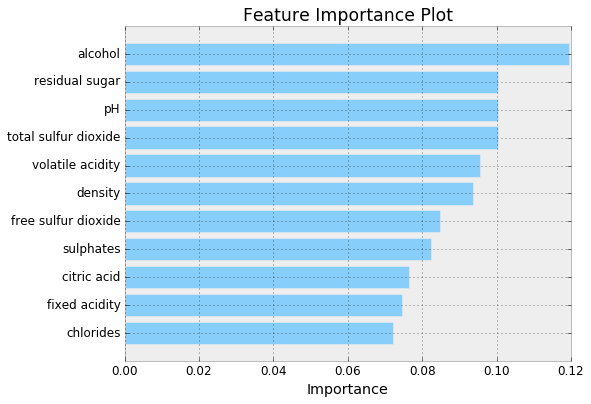

In [6]:
def viz_importance(model, feature_names, n_features):
    """Visualize the relative importance of predictors"""
    # sort the importance in decreasing order
    importances = model.feature_importances_
    idx = np.argsort(importances)[-n_features:]
    names = feature_names[idx]
    scores = importances[idx]
    
    y_pos = np.arange(1, n_features + 1)
    plt.barh(y_pos, scores, color = 'lightskyblue', align = 'center')
    plt.yticks(y_pos, names)
    plt.xlabel('Importance')
    plt.title('Feature Importance Plot')
    
viz_importance(gbm, wine.columns[:-1], X.shape[1])

But the way the ensembles are constructed differs substantially between each model. In Random Forests and Extra Trees, all trees are created independently and each tree contributes equally to the final model. The trees in Gradient Boosting, however, are dependent on past trees and contribute unequally to the final model. Despite these differences, Random Forests, Extra Trees and Gradient Boosting all offer competitive predictive performance (Gradient Boosting often wins when carefully tuned). As for computation time, Gradient Boosting is often greater than for Random Forests, Extra Trees, since their procedure can be easily parallel processed given that the trees are created independently.

## Classification

Gradient Boosting Machine can also be extended to handle classification tasks, as we'll soon see, even in the classification context, the underlying algorithm is still a regression tree. To adapt the algorithm to a classification process, we start by defining a new loss function, cross entropy (also known as multinomial deviance), denoted as:

$$L\big(y_i, F(x_i)\big) = -\sum_k ^ K y_k(x_i) \log p_k(x_i)$$

The notation above says:

- We have a total of $K$ output class (categorical response variable) that ranges from $1, ..., K$
- $y_k(x_i)$ is a dummy indicator of the response variable that takes the value of 1 if the $i_{th}$ observation belongs to class $k$ and 0 otherwise
- $p_k(x_i)$ is the predicted probability of the $i_{th}$ observation belonging to class $k$

So the next question is how do we get $p_k(x_i)$?

### Softmax

Softmax function takes an $N$-dimensional vector of arbitrary real values and produces another $N$-dimensional vector with real values in the range (0, 1) that add up to 1. The function's formula can be written as:

$$p_i = \frac{e^{o_i}}{\sum_k^K e^{o_k}}$$

For example, in the following code chunk, we see that how the softmax function transforms a 3-element vector 1.0, 2.0, 3.0 into probabilities that sums up to 1, while still preserving the relative size of the original elements.

In [7]:
def compute_softmax(x):
    """compute the softmax of vector"""
    exp_x = np.exp(x)
    softmax = exp_x / np.sum(exp_x)
    return softmax

# this can be interpreted as the probability
# of belonging to the three classes
compute_softmax([1, 2, 3])

array([ 0.09003057,  0.24472847,  0.66524096])

Next, we wish to compute the derivative of this function with respect to the input $o_i$ so we can use it later when computing the derivative of the loss function. To be explicit we wish to find:

$$\frac{\partial p_i}{\partial o_j} = \frac{\partial \frac{e^{o_i}}{\sum_{k=1}^{N}e^{o_k}}}{\partial o_j}$$

For any arbitrary output $i$ and input $j$. To do so, We'll be using the quotient rule of derivatives. The rule tells us that for a function $f(x) = \frac{g(x)}{h(x)}$:

$$f'(x) = \frac{g'(x)h(x) - h'(x)g(x)}{[h(x)]^2}$$

In our case, we have:

\begin{align*}
g &= e^{o_i} \nonumber \\
h &= \sum_{k=1}^{K}e^{o_k} \nonumber
\end{align*}

It's important to notice that no matter which $o_j$ we compute the derivative of $h$ for the output will always be $e^{o_j}$. Howewer, this is not the case for $g$. It's derivative will be $e^{o_j}$ only if $i = j$, because only then will it have the term $e^{o_j}$. Otherwise, the derivative is simply 0 (because it's simply taking the derivative of a constant).

So going back to using our quotient rule, we start with the $i = j$ case. In the following derivation we'll use the $\Sigma$ (Sigma) sign to represent $\sum_{k=1}^{K}e^{o_k}$ for simplicity and to prevent cluttering up the notation.

\begin{align*}
\frac{\partial \frac{e^{o_i}}{\sum_{k = 1}^{N} e^{o_k}}}{\partial o_j} 
&= \frac{e^{o_i}\Sigma-e^{o_j}e^{o_i}}{\Sigma^2} \nonumber \\
&= \frac{e^{o_i}}{\Sigma}\frac{\Sigma - e^{o_j}}{\Sigma} \nonumber \\
&= p_i(1 - p_j) \nonumber \\
&= p_i(1 - p_i) \nonumber
\end{align*}

The reason we can perform the operation in the last line is because we're considering the scenario where $i = j$. Similarly we can do the case where $i \neq j$.

\begin{align*}
\frac{\partial \frac{e^{o_i}}{\sum_{k = 1}^{N} e^{o_k}}}{\partial o_j} 
&= \frac{0-e^{o_j}e^{o_i}}{\Sigma^2} \nonumber \\
&= -\frac{e^{o_j}}{\Sigma}\frac{e^{o_i}}{\Sigma} \nonumber \\
&= -p_j p_i \nonumber \\
&= -p_i p_j \nonumber
\end{align*}

Just to sum it up, we now have:

$$\frac{\partial p_i}{\partial o_j} = p_i(1 - p_i),\quad i = j$$

$$\frac{\partial p_i}{\partial o_j} = -p_i p_j,\quad i \neq j$$

Given this, we can tie this back to the original loss function $-\sum_k^K y_k \log p_k \nonumber \\$ and compute it's negative gradient.

\begin{align}
\frac{\partial L}{\partial o_i} 
&= -\sum_k y_k\frac{\partial \log p_k}{\partial o_i} \nonumber \\
&= -\sum_k y_k\frac{1}{p_k}\frac{\partial p_k}{\partial o_i} \nonumber \\
&= -y_i(1-p_i) - \sum_{k \neq i}y_k\frac{1}{p_k}(-p_kp_i) \nonumber \\
&= -y_i(1 - p_i) + \sum_{k \neq i}y_k(p_i) \nonumber \\
&= -y_i + y_i p_i + \sum_{k \neq i}y_k(p_i) \nonumber \\
&= p_i\left(\sum_ky_k\right) - y_i \nonumber \\
&= p_i - y_i \nonumber
\end{align} 

Remember $\sum_ky_k=1$ (as $y$ is a vector with only one non-zero element, which is $1$ when the indicating the observation belongs to the $k_{th}$ class. 

After a long journey, we now see, for every class $k$, the gradient is the difference between the associated dummy variable and the predicted probability of belonging to that class. This is essentially the "residuals" from the classification gradient boosting. Given this, we can now implement the algorithm, the overall process of training a regression tree has still not changed, only now we must deal with the dummy variables, $y_k$ and fit a regression tree on the negative gradient for each dummy variable.

## Implementation

For the dataset, we'll still use the Wine Quality Data Set that was used for the regression task, except we now treat the quality of the wine (a scale of 1 ~ 10) as categorical instead of numeric.

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [9]:
class GBMClass:
    """
    classification gradient boosting machine using scikit learn's 
    decision tree as the base tree
    
    Parameters
    ----------
    n_estimators: int
        number of trees to train
        
    learning_rate: float
        learning rate, some calls it shrinkage, 
        shrinks the contribution of each tree
        to prevent overfitting
        
    max_depth: int
        controls how deep to grow the tree;
        this is more of a decision tree parameter,
        it is tune here to make later comparison fair
    
    all the other parameters for a decision tree like
    max_features or min_sample_split also applies to GBM, 
    it is just not used here as that is more
    related to a single decision tree
    """
    def __init__(self, n_estimators, learning_rate, max_depth):
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate

    def fit(self, X, y):
        # encode labels with value between 0 and n_class - 1,
        # so we can easily one-hot encode them
        self.le = LabelEncoder()
        labels = self.le.fit_transform(y)
        Y = self._to_categorical(labels)
        del labels
        
        # the predicted probability starts out with 
        # a value that's uniform over all classes;
        # then we compute the residuals (negative gradient),
        # which is the difference between the predicted
        # probability and the class label
        y_proba = np.full( Y.shape, 1 / Y.shape[1] ) 
        residuals = Y - y_proba
        
        # train a base decision tree on the residuals
        # for every single class, hence we end up with
        # n_estimators * n_class base tree models
        self.estimators = []
        for i in range(self.n_estimators):
            for j in range(self.n_class): 
                tree = DecisionTreeRegressor(max_depth = self.max_depth)
                tree.fit(X, residuals[:, j])   
                y_pred = tree.predict(X)
                self.estimators.append(tree)  
                residuals[:, j] -= self.learning_rate * y_pred
                
        return self
            
    def _to_categorical(self, y):
        """one hot encode class vector y"""
        self.n_class = np.amax(y) + 1
        Y = np.zeros(( y.shape[0], self.n_class ))
        for i in range(y.shape[0]):
            Y[i, y[i]] = 1.0

        return Y
    
    def predict(self, X):
        # after predicting the class remember to
        # transform it back to the actual class label
        y_prob = self.predict_proba(X)
        y_pred = np.argmax(y_prob, axis = 1)
        y_pred = self.le.inverse_transform(y_pred)
        return y_pred
    
    def predict_proba(self, X):
        # add up raw score for every class and convert
        # it to probability using softmax
        y_raw = np.zeros(( X.shape[0], self.n_class ))
        index = 0
        for tree in self.estimators:
            if not index % self.n_class:
                index = 0

            y_raw[:, index] += self.learning_rate * tree.predict(X)
            index += 1
        
        y_proba = self._compute_softmax(y_raw)
        return y_proba
    
    def _compute_softmax(self, z):
        """
        compute the softmax of matrix z in a numerically stable way,
        by substracting each row with the max of each row
        """
        shift_z = z - np.amax(z, axis = 1, keepdims = 1)
        exp_z = np.exp(shift_z)
        softmax = exp_z / np.sum(exp_z, axis = 1, keepdims = 1)
        return softmax    

In [10]:
# compare the results between a single decision tree,
# gradient boosting, the higher the accuracy, the better
tree = DecisionTreeClassifier(max_depth = 6)
tree.fit(X_train, y_train) 
tree_y_pred = tree.predict(X_test)
print( 'tree: ', accuracy_score(y_test, tree_y_pred) )

# gradient boosting for 150 trees and learning rate of 0.2
# unlike random forest, gradient boosting's base tree can be shallower
# meaning that there depth can be smaller
gbm_class = GBMClass(n_estimators = 150, learning_rate = 0.2, max_depth = 3)
gbm_class.fit(X_train, y_train)
gbm_class_y_pred = gbm_class.predict(X_test)
print( 'gbm: ', accuracy_score(y_test, gbm_class_y_pred) )

# library to confirm results are comparable
gbm = GradientBoostingClassifier(n_estimators = 150, learning_rate = 0.2, max_depth = 3)
gbm.fit(X_train, y_train)
gbm_y_pred = gbm.predict(X_test)
print( 'gbm library: ', accuracy_score(y_test, gbm_y_pred) )

tree:  0.516326530612
gbm:  0.591836734694
gbm library:  0.589795918367


## Understanding Model Complexity

In the following section, we generate a Sinoide function + random gaussian noise, with 80 training samples (blue points) and 20 test samples (red points).

In [11]:
def ground_truth(x):
    """Ground truth -- function to approximate"""
    return x * np.sin(x) + np.sin(2 * x)

def gen_data(low, high, n_samples):
    """generate training and testing data from the ground truth function"""
    np.random.seed(15)
    X = np.random.uniform(low, high, size = n_samples)
    
    # generate the response from the ground truth function and add
    # some random noise to it
    y = ground_truth(X) + np.random.normal(scale = 2, size = n_samples)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
    return X_train, X_test, y_train, y_test

def plot_data(x_plot, X_train, X_test, y_train, y_test):
    """plot training and testing data"""
    s = 20
    alpha = 0.4
    plt.plot(x_plot, ground_truth(x_plot), alpha = alpha, label = 'ground truth')
    plt.scatter(X_train, y_train, s = s, alpha = alpha)
    plt.scatter(X_test, y_test, s = s, alpha = alpha, color = 'red')
    plt.xlim(( 0, 10 ))
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend(loc = 'upper left')
    plt.show()

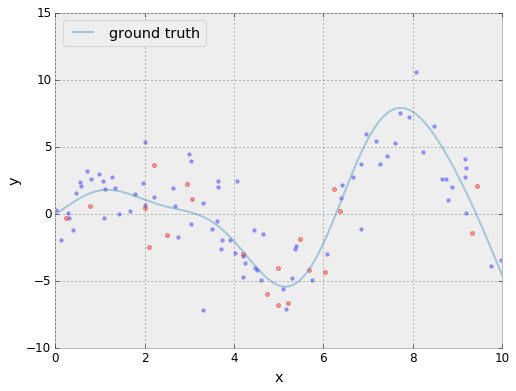

In [12]:
low = 0
high = 10
x_plot = np.linspace(low, high, 500)
X_train, X_test, y_train, y_test = gen_data(low = low, high = high, n_samples = 100)
plot_data(x_plot, X_train, X_test, y_train, y_test)

Recall that in a single regression tree, we can use the `max_depth` parameter to control how deep to grow the tree and the deeper the tree the more variance can be explained.

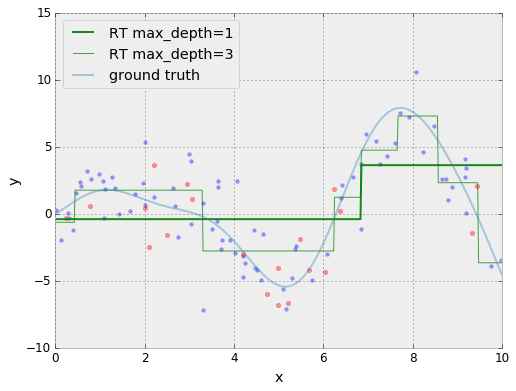

In [13]:
# when using scikit-learn, the training data has to be
# a 2d-array even if it only has 1 features
tree1 = DecisionTreeRegressor(max_depth = 1)
tree1.fit(X_train[:, np.newaxis], y_train)
tree2 = DecisionTreeRegressor(max_depth = 3)
tree2.fit(X_train[:, np.newaxis], y_train)

plt.plot(x_plot, tree1.predict(x_plot[:, np.newaxis]),
         label = 'RT max_depth=1', color = 'g', alpha = 0.9, linewidth = 2)
plt.plot(x_plot, tree2.predict(x_plot[:, np.newaxis]),
         label = 'RT max_depth=3', color = 'g', alpha = 0.7, linewidth = 1)
plot_data(x_plot, X_train, X_test, y_train, y_test)

The plot above shows that the decision boundaries made by decision trees are always perpendicular to $x$ and $y$ axis (due to the fact that they consists of nested if-else statements). Let's see what happens when we use gradient boosting without tuning the parameters (by specifying a fix `max_depth`).

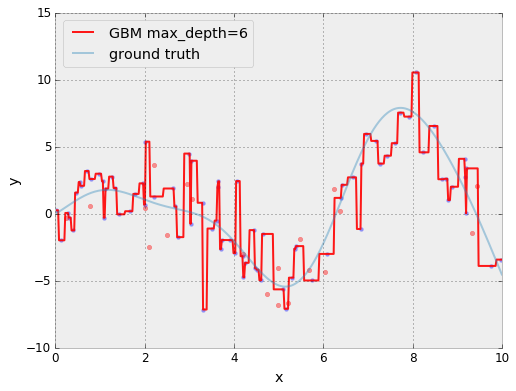

In [14]:
gbm = GradientBoostingRegressor(n_estimators = 300, max_depth = 6, learning_rate = 0.1)
gbm.fit(X_train[:, np.newaxis], y_train)

plt.plot(x_plot, gbm.predict(x_plot[:, np.newaxis]),
         label = 'GBM max_depth=6', color = 'r', alpha = 0.9, linewidth = 2)
plot_data(x_plot, X_train, X_test, y_train, y_test)

Hopefully, it should be clear that compared with decision trees, gradient boosting machine is far more susceptible to overfitting the training data, hence it is common to tune parameters including `max_depth`, `max_features`, `min_samples_leaf`, `subsample` (explained below) to reduce the overfitting phenomenon from  occurring.

The parameter `subsample` (technically called *stochastic gradient boosting*) borrows some idea from bagging techniques. What it does is: while iterating through each individual tree building process, it randomly select a fraction of the training data. Then the residuals and models in the remaining steps of the current iteration are based only on that sample of data. It turns out that this simple modification improved the predictive accuracy of boosting while also reducing the required computational resources (of course, this is based on the fact that you have enough observations to subsample).

The following section tunes the commonly tuned parameter and find the best one and draws the decision boundary. The resulting plot should be self-explanatory.

Best hyperparameters: {'min_samples_leaf': 5, 'max_depth': 4, 'subsample': 0.9}


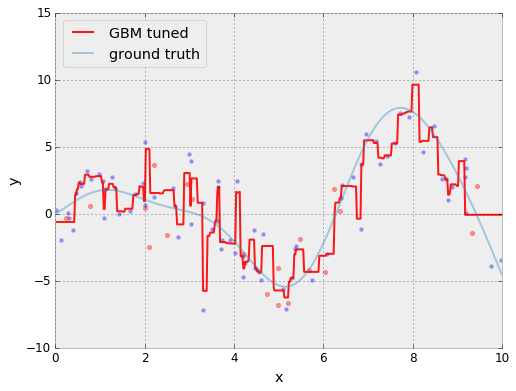

In [15]:
param_grid = {
    'max_depth': [4, 6],
    'min_samples_leaf': [3, 5, 8],
    'subsample': [0.9, 1]
    # 'max_features': [1.0, 0.3, 0.1] # not possible in this example (there's only 1)
}
gs_gbm = GridSearchCV(gbm, param_grid, scoring = 'neg_mean_squared_error', n_jobs = 4)
gs_gbm.fit(X_train[:, np.newaxis], y_train)
print('Best hyperparameters: %r' % gs_gbm.best_params_)

plt.plot(x_plot, gs_gbm.predict(x_plot[:, np.newaxis]),
         label = 'GBM tuned', color = 'r', alpha = 0.9, linewidth = 2)
plot_data(x_plot, X_train, X_test, y_train, y_test)

## Reference

- [Slide: Gradent boosting](http://eric.univ-lyon2.fr/~ricco/cours/slides/en/gradient_boosting.pdf)
- [Slide: A gentle introduction to gradient boosting](http://www.ccs.neu.edu/home/vip/teach/MLcourse/4_boosting/slides/gradient_boosting.pdf)
- [Blog: The Softmax function and its derivative](http://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/)
- [Notebook: Regression Trees and Rule-Based Models](http://nbviewer.jupyter.org/github/leig/Applied-Predictive-Modeling-with-Python/blob/master/notebooks/Chapter%208.ipynb)
- [Notebook: Gradient Boosted Regression Trees in scikit-learn](http://nbviewer.jupyter.org/github/pprett/pydata-gbrt-tutorial/blob/master/gbrt-tutorial.ipynb)
- [StackExchange: Derivative of Softmax loss function](http://math.stackexchange.com/questions/945871/derivative-of-softmax-loss-function)
- [StackExchange: How are individual trees added together in boosted regression tree?](http://stats.stackexchange.com/questions/135378/how-are-individual-trees-added-together-in-boosted-regression-tree)